In [1]:
import numpy as np
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor

In [2]:
transform = Compose([ToTensor(), nn.Flatten(start_dim=0)])
dataset = MNIST('dataset', transform=transform, download=True)
loader = DataLoader(dataset, batch_size=128)
x, y = next(iter(loader))

In [3]:
from modules import SparseWeights, KWinners

model = nn.Sequential(*[
    SparseWeights(nn.Linear(28*28, 128), weightSparsity=.4),
    KWinners(128, 64),
    SparseWeights(nn.Linear(128, 64), weightSparsity=.4),
    KWinners(64, 32),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
])

# model = nn.Sequential(*[
#     nn.Linear(28*28, 512),
#     nn.ReLU(inplace=True),
#     nn.Linear(512, 128),
#     nn.ReLU(inplace=True),
#     nn.Linear(128, 64),
#     nn.ReLU(inplace=True),
#     nn.Linear(64, 10),
#     nn.LogSoftmax(dim=1)
# ])


In [5]:
from tqdm import tqdm

n_epoch = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

for epoch in epoch_iterator:
    for input, target in loader:
        input = input.to(device)
        target = target.to(device)

        out = model(input)
        loss = criterion(out, target)

        epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


100%|██████████| 10/10 [03:24<00:00, 20.40s/epoch, tls=0.1486]


# AutoEncoder

In [6]:
# model = nn.Sequential(*[
#     SparseWeights(nn.Linear(28*28, 128), weightSparsity=.4),
#     KWinners(128, 100),
#     SparseWeights(nn.Linear(128, 64), weightSparsity=.4),
#     KWinners(64, 32),
#     nn.Linear(64, 128),
#     nn.ReLU(inplace=True),
#     nn.Linear(128, 28*28),
#     nn.ReLU(inplace=True)
# ])

# model = nn.Sequential(*[
#     nn.Linear(28*28, 128),
#     KWinners(128, 100),
#     nn.Linear(128, 64),
#     KWinners(64, 32),
#     nn.Linear(64, 128),
#     nn.ReLU(inplace=True),
#     nn.Linear(128, 28*28),
#     nn.ReLU(inplace=True)
# ])
model = nn.Sequential(*[
    nn.Linear(28*28, 128),
    KWinners(128, 32),
    nn.Linear(128, 28*28),
    nn.ReLU(inplace=True)
])


In [7]:
from tqdm import tqdm

n_epoch = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

for epoch in epoch_iterator:
    for input, _ in loader:
        input = input.to(device)

        out = model(input)
        loss = criterion(out, input)

        epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

 70%|███████   | 7/10 [01:50<00:47, 15.72s/epoch, tls=0.0095]


KeyboardInterrupt: 

In [14]:
from torchvision.transforms import ToPILImage

to_img = ToPILImage()
img_in = to_img(input[0].reshape(1,28,28))
img_out = to_img(out[0].reshape(1,28,28))


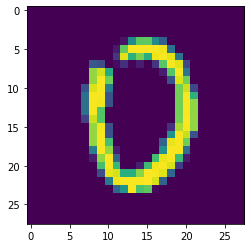

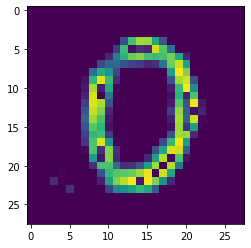

In [15]:
from matplotlib import pyplot as plt
plt.imshow(img_in)
plt.show()
plt.imshow(img_out)
plt.show()

In [16]:
model[1].maxEntropy()

103.843599930769

In [17]:
model[1].entropy()

tensor(80.3929, device='cuda:0')

In [70]:
from modules.utils import plotDutyCycles, binaryEntropy
plotDutyCycles(model[1].dutyCycle.cpu(), 'test.png')

AttributeError: 'numpy.ndarray' object has no attribute 'log2'

In [68]:
_,entropy = binaryEntropy(model[1].dutyCycle.cpu())
bins = np.linspace(0.0, 0.3, 25)

(array([37.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  2.,
         2.,  1.,  0.,  0.,  1.,  2.,  3.,  4.,  4.,  2.,  3.]),
 array([0.    , 0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875,
        0.1   , 0.1125, 0.125 , 0.1375, 0.15  , 0.1625, 0.175 , 0.1875,
        0.2   , 0.2125, 0.225 , 0.2375, 0.25  , 0.2625, 0.275 , 0.2875,
        0.3   ]),
 <BarContainer object of 24 artists>)

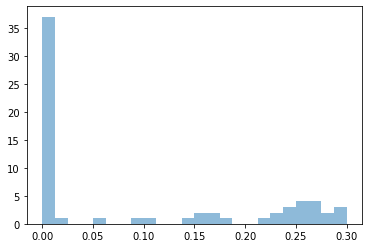

In [69]:
plt.hist(model[1].dutyCycle.cpu().numpy(), bins, alpha=0.5, label='All cols')

In [32]:
model[1].dutyCycle.shape

torch.Size([128])

Text(0, 0.5, 'Number of units')

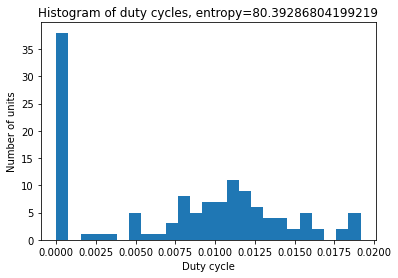

In [73]:
bins = np.linspace(0.0, 0.03, 25)
plt.hist((model[1].dutyCycle / 32).cpu().numpy(), bins=25)
plt.title("Histogram of duty cycles, entropy=" + str(float(model[1].entropy())))
plt.xlabel("Duty cycle")
plt.ylabel("Number of units")

In [40]:
bins = np.linspace(0.0, 0.3, 25)
bins

array([0.    , 0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875,
       0.1   , 0.1125, 0.125 , 0.1375, 0.15  , 0.1625, 0.175 , 0.1875,
       0.2   , 0.2125, 0.225 , 0.2375, 0.25  , 0.2625, 0.275 , 0.2875,
       0.3   ])

In [57]:
test = model[1].dutyCycle.cpu().numpy()
np.histogram(test)

(array([39,  2,  5,  5, 17, 21, 15, 10,  7,  7]),
 array([4.2038954e-45, 6.1255079e-02, 1.2251016e-01, 1.8376523e-01,
        2.4502032e-01, 3.0627540e-01, 3.6753047e-01, 4.2878556e-01,
        4.9004063e-01, 5.5129570e-01, 6.1255080e-01], dtype=float32))

(array([39.,  2.,  5.,  5., 17., 21., 15., 10.,  7.,  7.]),
 array([4.2038954e-45, 6.1255079e-02, 1.2251016e-01, 1.8376523e-01,
        2.4502032e-01, 3.0627540e-01, 3.6753047e-01, 4.2878556e-01,
        4.9004063e-01, 5.5129570e-01, 6.1255080e-01], dtype=float32),
 <BarContainer object of 10 artists>)

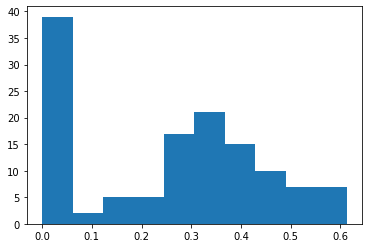

In [58]:
plt.hist(test)

In [74]:
from torch.nn.functional import kl_div

In [98]:
kl_div(torch.tensor(0.15), torch.tensor(0.05), False, log_target=False)

tensor(-0.1573)

In [212]:
rho = torch.tensor(0.05).reshape(1,1)
rho_hat = torch.tensor([0.25]).reshape(1,1)
torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat)))

tensor(0.1441)

In [213]:
import torch.nn.functional as F
def kl_divergence(p, q):
    # rho_hat = torch.mean(F.sigmoid(q), 1) # sigmoid because we need the probability distributions
    # rho = torch.ones(rho_hat.shape).to(p.device) * p
    rho_hat = torch.mean(q, 1)
    rho = torch.tensor([p] * len(rho_hat)).to(device)
    return torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat)))

In [214]:
kl_divergence(rho.cuda(), rho_hat.cuda())

tensor(0.1441, device='cuda:0')

In [167]:
rho.device

device(type='cpu')

In [108]:
torch.mean(F.sigmoid(rho_hat),1)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [122]:
a = torch.rand(12,5)
torch.mean(a, dim=1)

tensor([0.6612, 0.1495, 0.7421, 0.5153, 0.3172, 0.6749, 0.4633, 0.4487, 0.5462,
        0.2260, 0.5061, 0.5106])

In [123]:
a

tensor([[0.5840, 0.2297, 0.7432, 0.9449, 0.8040],
        [0.0377, 0.0846, 0.4192, 0.0822, 0.1237],
        [0.4357, 0.9356, 0.7535, 0.9195, 0.6661],
        [0.7359, 0.2475, 0.8716, 0.3167, 0.4048],
        [0.3079, 0.2874, 0.8764, 0.0378, 0.0763],
        [0.5345, 0.8033, 0.7135, 0.8818, 0.4416],
        [0.5303, 0.4038, 0.6455, 0.4945, 0.2427],
        [0.1572, 0.7321, 0.5589, 0.3041, 0.4912],
        [0.7669, 0.3590, 0.7498, 0.6519, 0.2034],
        [0.3286, 0.0564, 0.2545, 0.3861, 0.1044],
        [0.9624, 0.1955, 0.9534, 0.0600, 0.3592],
        [0.8041, 0.2507, 0.4543, 0.1008, 0.9429]])

In [124]:
[1] * 6

[1, 1, 1, 1, 1, 1]

In [149]:
a = torch.rand(1,5)
a

tensor([[0.7767, 0.0412, 0.5384, 0.3172, 0.6350]])

In [151]:
a.expand(2,-1)

tensor([[0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350]])

In [152]:
torch.ones(25,5) * a

tensor([[0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],
        [0.7767, 0.0412, 0.5384, 0.3172, 0.6350],


In [4]:
from modules import ReLUWithSparsity

model = nn.Sequential(*[
    nn.Linear(28*28, 128),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(128),
    nn.Linear(128, 32),
    ReLUWithSparsity(beta=1e-6, rho=0.05),
    nn.BatchNorm1d(32),
    nn.Linear(32, 128),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(128),
    nn.Linear(128, 28*28),
    nn.ReLU(inplace=True)
])

In [5]:
from tqdm import tqdm

n_epoch = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

for epoch in epoch_iterator:
    for input, _ in loader:
        input = input.to(device)

        out = model(input)
        loss = criterion(out, input)

        epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [01:39<00:00,  9.94s/epoch, tls=0.0433]


In [6]:
from torchvision.transforms import ToPILImage

to_img = ToPILImage()
img_in = to_img(input[1].reshape(1,28,28))
img_out = to_img(out[1].reshape(1,28,28))


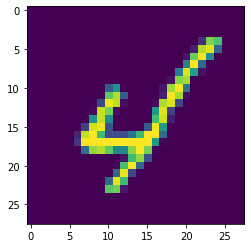

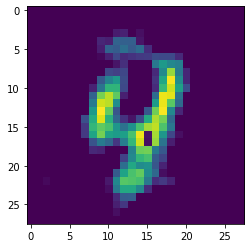

In [7]:
from matplotlib import pyplot as plt
plt.imshow(img_in)
plt.show()
plt.imshow(img_out)
plt.show()

In [49]:

model = nn.Sequential(*[
    nn.Conv2d(1, 1, 3, padding=1),
    ReLUWithSparsity(beta=1e-5, rho=0.05)
])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()


In [52]:
test = torch.rand(1,1,28,28, requires_grad=True)
test2 = torch.rand(1,1,28,28)
model(test).shape
loss = criterion(test, test2)
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [54]:
from functional.utils import kl_divergence

In [57]:
kl_divergence(0.05, torch.rand(1,1,28,28))

tensor(601.1711)

In [80]:
from torch.nn import functional as F

test = torch.rand(25,16)
rho_hat = torch.mean(F.sigmoid(test).flatten(1), 1) # sigmoid because we need the probability distributions

In [81]:
rho_hat.shape

torch.Size([25])

In [82]:
rho = torch.ones(rho_hat.shape) * 0.05

In [85]:
torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat))) * 1e-3

tensor(0.0185)